# Document Classifier using TorchText example

- This notebook demonstrates creation of aneural network in PyTorch to build a document classifier

- Will create labels to assign the news articles based on running ReLu activation math on the output layer
AG_NEWS dataset from HuggingFace is stored in Parquet format. Hugging Face datasets library depends on PyArrow to read Parquet files thus PyArrow is required to read the dataset used in this notebook.



In [108]:
# Import PyTorch and torchtext
import torch
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torch.utils.data import DataLoader

In [109]:
import sys, os
os.system(f"{sys.executable} -m pip install datasets")

Defaulting to user installation because normal site-packages is not writeable


0

In [110]:
from datasets import load_dataset

# Load AG_NEWS dataset from Hugging Face
dataset = load_dataset("ag_news")

# Create train/validation/test splits to prevent data leakage
full_train = dataset["train"]
test_data = dataset["test"]

# Split training data into train (80%) and validation (20%)
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size

# Create splits
train_data = full_train.select(range(train_size))
val_data = full_train.select(range(train_size, train_size + val_size))

# Examine first example from training data
y, text = train_data[0]["label"], train_data[0]["text"]
print(y, text)

# Labels stored as a python dictionary
ag_news_label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
print(ag_news_label[y])

# Print dataset sizes
print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

2 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Business
Train: 96000, Validation: 24000, Test: 7600


## Build the standard text processing pipeline

In [84]:
#Import libraries for text processing and model building 

from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch.utils.data import DataLoader

In [85]:
# Setup Tokenizer and Build Vocabulary

# Initialize tokenizer
tokenizer = get_tokenizer("basic_english")

# Function to yield tokens from dataset
def yield_tokens(data_iter):
    for item in data_iter:
        yield tokenizer(item["text"])  # Fixed: access text field correctly

# Build vocabulary from training data
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 84759


In [86]:
#Create text and label processing pipelines

def text_pipeline(x):
    return vocab(tokenizer(x))

# Label processing pipeline: already 0-indexed in Hugging Face, no need to subtract 1
def label_pipeline(x):
    return int(x)  # Fixed: removed -1 since HF labels are already 0-indexed

# Test the pipelines
sample_text = train_data[0]["text"]
sample_label = train_data[0]["label"]
print(f"Original text: {sample_text[:50]}...")
print(f"Tokenized: {tokenizer(sample_text)[:10]}")
print(f"Text pipeline output: {text_pipeline(sample_text)[:10]}")
print(f"Label pipeline output: {label_pipeline(sample_label)}")


Original text: Wall St. Bears Claw Back Into the Black (Reuters) ...
Tokenized: ['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(']
Text pipeline output: [413, 409, 1, 1662, 14051, 112, 64, 2, 771, 13]
Label pipeline output: 2


## Set up a batch function for embedding bags and code for appending labels from each sample to a batch

In [111]:
#Create Batch Collaation Function 

# Batch collation function for DataLoader
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    
    for item in batch:  # Fixed: iterate over batch items correctly
        _label = item["label"]  # Fixed: access label field
        _text = item["text"]    # Fixed: access text field
        
        # Process label and text
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))  # Fixed: offsets -> offsets
    
    # Convert to tensors
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    
    return label_list, text_list, offsets

# Test the collate function
test_batch = [train_data[i] for i in range(3)]
labels, texts, offsets = collate_batch(test_batch)
print(f"Batch labels: {labels}")
print(f"Batch text length: {len(texts)}")
print(f"Offsets: {offsets}")

Batch labels: tensor([2, 2, 2])
Batch text length: 111
Offsets: tensor([ 0, 29, 71])


In [112]:
#Create DataLoader with a batch size of 3
BATCH_SIZE = 3

def convert_dataset(hf_dataset):
    return [{"label": item["label"], "text": item["text"]} for item in hf_dataset]

# Convert all datasets
train_dataset = convert_dataset(train_data)
val_dataset = convert_dataset(val_data)
test_dataset = convert_dataset(test_data)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"Train: {len(train_dataloader)} batches, Val: {len(val_dataloader)} batches, Test: {len(test_dataloader)} batches")

#Test DataLoader
for i, (labels, texts, offsets) in enumerate(train_dataloader):
    print(f"Batch {i+1}: Labels {labels.shape}, Texts {texts.shape}, Offsets {offsets.shape}")
    if i == 1: break  # Show 2 batches only

Train: 32000 batches, Val: 8000 batches, Test: 2534 batches
Batch 1: Labels torch.Size([3]), Texts torch.Size([121]), Offsets torch.Size([3])
Batch 2: Labels torch.Size([3]), Texts torch.Size([136]), Offsets torch.Size([3])


In [113]:
import torch.nn as nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):  
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [114]:
# Create instance of text classification

emsize = 64 
vocab_size = len(vocab)
num_class = 4 
model = TextClassificationModel(vocab_size, emsize, num_class)


## Training the Model

In [115]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

losses, accuracies = [], []

#Use higher epochs when training in Production
for epoch in range(5):
    model.train()
    total_loss, correct = 0, 0
    for labels, texts, offsets in tqdm(train_dataloader, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        output = model(texts, offsets)
        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        correct += (output.argmax(1) == labels).sum().item()
    
    scheduler.step()
    
    # Validation evaluation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for labels, texts, offsets in val_dataloader:
            output = model(texts, offsets)
            val_correct += (output.argmax(1) == labels).sum().item()
    
    epoch_loss = total_loss/len(train_dataloader)
    epoch_acc = 100*correct/len(train_dataset)
    val_acc = 100*val_correct/len(val_dataset)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}: Loss={epoch_loss:.3f}, Train={epoch_acc:.1f}%, Val={val_acc:.1f}%, LR={current_lr:.4f}')

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 32000/32000 [00:56<00:00, 570.65it/s]


Epoch 1: Loss=0.607, Train=78.5%, Val=85.8%, LR=0.1000


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 32000/32000 [00:57<00:00, 555.25it/s]


Epoch 2: Loss=0.336, Train=89.1%, Val=87.8%, LR=0.1000


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 32000/32000 [00:56<00:00, 569.80it/s]


Epoch 3: Loss=0.292, Train=90.7%, Val=88.7%, LR=0.0500


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 32000/32000 [00:53<00:00, 595.52it/s]


Epoch 4: Loss=0.262, Train=91.8%, Val=88.9%, LR=0.0500


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 32000/32000 [00:54<00:00, 585.94it/s]


Epoch 5: Loss=0.251, Train=92.2%, Val=88.9%, LR=0.0500


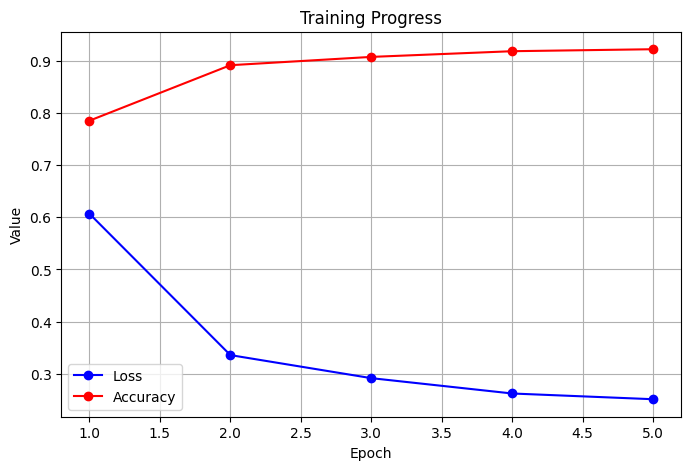

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), losses, 'b-o', label='Loss')
plt.plot(range(1, 6), [acc/100 for acc in accuracies], 'r-o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
# Prediction function works on real text 

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))  
        output = model(text, torch.tensor([0]))  
        return ag_news_label[output.argmax(1).item()]

predict("I like money", text_pipeline)

'Business'

In [121]:
# Test on custom text samples
test_samples = [
    "Stock market reaches new highs today",
    "Football team wins championship", 
    "Scientists discover new planet",
    "Breaking news from around the world"
]

model.eval()
for text in test_samples:
    prediction = predict(text, text_pipeline)
    print(f"'{text}' → {prediction}")

'Stock market reaches new highs today' → Business
'Football team wins championship' → Sports
'Scientists discover new planet' → Sci/Tech
'Breaking news from around the world' → Sci/Tech


In [122]:
import random

test_data = dataset["test"]
sample_size = 50
indices = random.sample(range(len(test_data)), sample_size)

model.eval()
correct = 0

for i, idx in enumerate(indices):
   sample = test_data[idx]
   true = ag_news_label[sample["label"]]
   pred = predict(sample["text"], text_pipeline)
   
   correct += (pred == true)
   
   if i < 10:
       status = "✓" if pred == true else "✗"
       print(f"{status} {pred} (actual: {true})")
       print(f"   {sample['text'][:65]}...")
       print()

print(f"Tested {sample_size} random samples")
print(f"Got {correct} right ({100*correct/sample_size:.1f}% accuracy)")

✓ Sports (actual: Sports)
   Conte turned athletes into towers of power HE IS THE face of spor...

✓ Sports (actual: Sports)
   Kuznetsova Beats Sharapova to Make China Open Final  BEIJING (Reu...

✓ Business (actual: Business)
   Hurricane Worries Boost Oil Prices Worries that Hurricane Ivan wi...

✓ World (actual: World)
   Sudanese Decry UN Threat of Sanctions Sudan said Sunday that the ...

✓ Business (actual: Business)
   Nissan comes apart without parts Tokyo - Japan #39;s Nissan Motor...

✓ Sci/Tech (actual: Sci/Tech)
   Log on to be a satellite spy A Canadian inventor has created Inte...

✓ Sports (actual: Sports)
   Sheffield day to day with sprained left ankle New York Yankees ri...

✗ World (actual: Sci/Tech)
   Hit TV series 24 goes from small screen to smaller screen (AFP) A...

✓ World (actual: World)
   Delegates Urge Cleric to Pull Out of Najaf BAGHDAD, Iraq - Delega...

✓ World (actual: World)
   Unrest Spreads To Southern Iraq (CBS/AP) As US forces continued t...

Tes